In [43]:
import numpy as np
from sklearn.decomposition import PCA 

In [44]:
from tensorflow.keras.datasets import mnist
(train_x, train_y) , (_, __) = mnist.load_data()

n = train_y.size 
train_x = train_x.reshape((n, train_x.size // n)).astype('float') / 128. - 1.

In [46]:
from collections import Counter
counts = Counter(train_y)
print(counts)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def Plotter(data, color = None, n = None, dim = None, random_rotation = False, cmap = None, s = 1,
            save = None, title = None):
    if n == None:   n = data.shape[0]
    if dim == None: dim = data.shape[1]
    if not color.any(): color = np.arange(n)
    if cmap == None: cmap = plt.cm.get_cmap()
    
    if random_rotation:
        rotation = np.random.randn((data.shape[1]*data.shape[1])).reshape((data.shape[1],data.shape[1]))
        rotation = np.linalg.qr(rotation)[0]
        data = data @ rotation

    if dim == 2:
        plt.scatter(data[:,-2],data[:,-1],c=np.arange(n)[color[:n]],cmap = plt.cm.get_cmap(), s = s)
    elif dim >= 3:
        fig = plt.figure()
        try:
            ax = Axes3D(fig, auto_add_to_figure=False)
            ax.scatter(data[:,-3],data[:,-2],data[:,-1],c=np.arange(n)[color[:n]],cmap=plt.cm.get_cmap(), s = s)
            fig.add_axes(ax)
        except:
            ax = Axes3D(fig)
            ax.scatter(data[:,-3],data[:,-2],data[:,-1],c=np.arange(n)[color[:n]],cmap=plt.cm.get_cmap(), s = s)
    
    if title:
        plt.title(title)
    if save:
        plt.savefig(save,dpi=500,bbox_inches='tight')
    plt.show()

In [48]:
def Orthonormalize(A):
    return np.linalg.qr(A)[0]

def LOBPCGsvd(A,x,maxiter = 100,retFrobeniusHistory=False):
    n = A.shape[0]
    if type(x) == int:
        m = x
        x = np.random.randn(n*m).reshape((n,m))
    else:
        m = x.shape[1]
        x = x.copy()
    x = Orthonormalize(x)
    
    x2 = np.linalg.eigh((x.T * A.T) @ (A * x))
    mu = x2[0]
    x2 = x2[1]
    x = x @ x2

    p = np.zeros((n,m))

    history = []
    for k in range(maxiter):
        Ax = A * x
        r = A.T * Ax - mu * x  # broadcast
        #print('mu =',mu)
        #print('re =',np.linalg.norm(r[:,0]))#,np.linalg.norm(r[:,1])
        r -= x @ (x.T @ r)
        #r = Tr  # preconditioner
        r = Orthonormalize(r)

        if k != 0:
            Ap = A * p
            if retFrobeniusHistory:
                history.append(np.linalg.norm(Ax))
            Ar = A * r
            if k == 1:
                gramA = np.zeros((3*m,3*m))
            gramA[:m,:m].flat[::m+1] = mu   # = np.diag(mu)
            gramA[:m,m:-m] = Ax.T @ Ar
            gramA[:m,-m:] = Ax.T @ Ap
            gramA[m:-m,m:-m] = Ar.T @ Ar
            gramA[m:-m,-m:] = Ar.T @ Ap
            gramA[-m:,-m:] = Ap.T @ Ap

            gramA[m:-m,:m]  = gramA[:m,m:-m].T
            gramA[-m:,:m]   = gramA[:m,-m:].T
            gramA[-m:,m:-m] = gramA[m:-m,-m:].T


            gramB = np.eye(3*m)
            gramB[:m,-m:] = x.T @ p
            gramB[m:-m,-m:] = r.T @ p

            gramB[-m:,:m]   = gramB[:m,-m:].T
            gramB[-m:,m:-m] = gramB[m:-m,-m:].T
        else: # k == 0:
            Ar = A * r

            gramA = np.zeros((2*m,2*m))
            gramA[:m,:m] = np.diag(mu)
            gramA[:m,m:] = Ax.T @ Ar
            gramA[m:,m:] = Ar.T @ Ar

            gramA[m:,:m] = gramA[:m,m:].T


            gramB = np.eye(2*m)
            gramB[:m,m:] = x.T @ r
            
            gramB[m:,:m] = gramB[:m,m:].T


        x2 = eigh(gramA,gramB,check_finite=False)
        #print(x2)
        iid = np.argsort(x2[0])[:m] 
        mu = x2[0][iid]
        x2 = x2[1][:,iid]

        if k != 0:
            p = p @ x2[-m:]
            p += r @ x2[m: -m]
        else: # k == 0:
            p = r @ x2[m:]
        
        x = x @ x2[:m] + p
        p = Orthonormalize(p)
        
    if retFrobeniusHistory:
        return x, mu, history
    return x, mu
        

In [49]:
from sklearn import neighbors
from scipy.linalg import solve, eigh
from scipy.sparse import linalg
from scipy import sparse
from time import time

def KNearest(X,k):
    nbors = neighbors.NearestNeighbors(n_neighbors=k+1,algorithm='ball_tree').fit(X)
    nbors = nbors.kneighbors(X,return_distance=False)[:,1:]
    return nbors

def ComputeWeight(X,Z,t,overwrite):
    C = X[Z] - X[t]
    G = C @ C.T
    trace = np.trace(G)
    reg = min(1e-3, 1e-3*trace)
    G.flat[::G.shape[0] + 1] += reg
    overwrite[:] = solve(G, np.ones(G.shape[0], dtype=G.dtype), sym_pos=True)
    overwrite *= 1. / np.sum(overwrite)

def GetWeights(X,k,Z):
    n = X.shape[0]
    w_data = np.zeros(n*k, dtype=X.dtype)
    for i, j in enumerate(range(0,n*k,k)):
        ComputeWeight(X,Z[i],i,w_data[j:j+k])
    return w_data

def Embedding(W,d,maxiter=1000,retFrobeniusHistory=False):
    #return np.linalg.svd(W.A)[2][-d-1:-1].T
    #eigs = linalg.lobpcg(W, np.random.randn(n*(d+1)).reshape((n,d+1)), largest=False)
    return LOBPCGsvd(W,d+1,maxiter=maxiter,retFrobeniusHistory=retFrobeniusHistory)

def LocallyLinearEmbedding(X,k,d,maxiter = -1,verbosityLevel = 1,retW = False,retFrobeniusHistory = False):
    n = X.shape[0]

    if maxiter < 0:
        maxiter = int(1000 * max(1, np.log(n) / 6.9))


    if verbosityLevel:
        print('Searching for K-Neighbors ... ', end = '')
        clock = time()
    nbors = KNearest(X,k)

    if verbosityLevel:
        print(' %f s\nComputing weights ... ' % (time() - clock), end = '')
        clock = time()
        
    w_data = GetWeights(X,k,nbors)
    W = sparse.csr_matrix((w_data, nbors.flatten(), np.arange(0,(n+1)*k,k)) , shape=(n,n))
    W = sparse.eye(n) - W
    #return W
    
    if verbosityLevel:
        print(' %f s\nComputing embeddings ...' % (time() - clock), end = '')
        clock = time()
    embeds = Embedding(W,d,maxiter,retFrobeniusHistory=retFrobeniusHistory)
    embedvec = embeds[0] * np.sqrt(n)
    
    if verbosityLevel:
        print(' %f s' % (time() - clock))
    
    if retFrobeniusHistory:
        if retW:
            return embedvec, W, embeds[2]
        else:
            return embedvec, embeds[2]
       
    if retW:
        return embedvec, W
    return embedvec

In [50]:
np.random.seed(0)
n = 3000
k = 10
maxiter = 1000
LLE_X, W, history = LocallyLinearEmbedding(train_x[:n], k = k, maxiter= maxiter, d = 3, 
                                            retW=True, retFrobeniusHistory=True)
#print('Ortho =',np.linalg.norm(LLE_X.T @ LLE_X - n * np.eye(LLE_X.shape[1]))/n)

Searching for K-Neighbors ...  10.374081 s
Computing weights ...  0.435501 s
Computing embeddings ... 1.770061 s


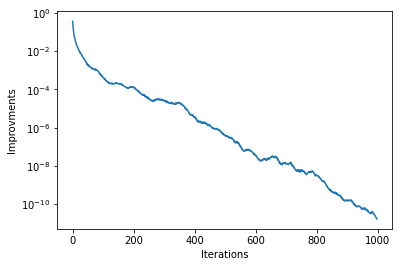

In [51]:
plt.plot(-np.array(history)[1:]+np.array(history)[:-1])
plt.semilogy()
plt.ylabel('Improvments')
plt.xlabel('Iterations')
plt.show()

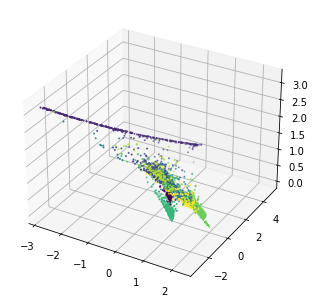

In [58]:
Plotter(LLE_X,dim=3,random_rotation=1,color=train_y,s=1)

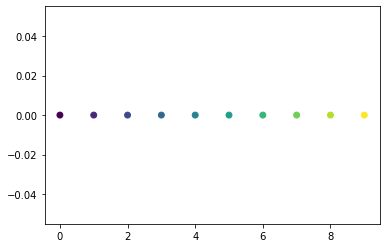

In [266]:
# see the figure-color mapping
Plotter(np.vstack((np.arange(10),np.zeros(10))).T, color=np.arange(10), s=35)

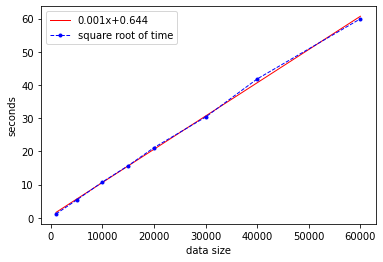

In [42]:
LLErunningtime = [1.39,28.9,116.6,247.2,447.6,921.5,1750.4,3592.9]  # k = 20
LLEsize = [1000,5000,10000,15000,20000,30000,40000,60000]
LLErunningtime = np.sqrt(np.array(LLErunningtime))
f = np.poly1d(np.polyfit(LLEsize,LLErunningtime,1))
plt.plot(np.arange(LLEsize[0],LLEsize[-1]), 
    f(np.arange(LLEsize[0],LLEsize[-1])),'r',linewidth=1)
plt.plot(LLEsize,LLErunningtime,'.--',linewidth=1,c='b')
plt.ylabel('seconds')
plt.xlabel('data size')
plt.legend(['0.001x+0.644','square root of time'])
#plt.savefig('Time 1.png',dpi=500,bbox_inches='tight')
plt.show()

In [40]:
center_x = train_x - np.mean(train_x,axis=0)
n = 60000
pca = PCA(n_components=3)
PCA_X = pca.fit_transform(center_x[:n])

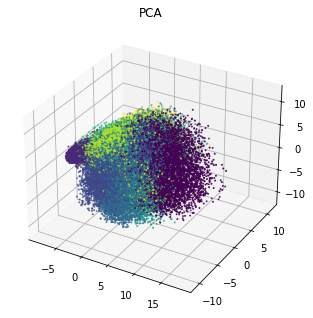

In [41]:
Plotter(PCA_X,dim=3,random_rotation=0,color=train_y,title='PCA')